In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
from pyramid.arima import auto_arima
from collections import defaultdict
from itertools import product
import pytemperature
import seaborn as sns

In [8]:
nights =  pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date', parse_dates=True, usecols=[*range(1, 15)])
nights.index.freq = 'MS'
temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2019.csv', parse_dates=True, index_col=0)
temp = pytemperature.c2k(temp)
daysoff_1017 = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv', parse_dates=True, index_col='date', usecols=[*range(1, 3)])
daysoff_1017.drop(daysoff_1017[(daysoff_1017.index>='2016-01-01')&(daysoff_1017.index<'2018-01-01')].index, inplace=True)
daysoff_1619 = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2016-2019.csv', parse_dates=True, index_col=0)
daysoff_1619.rename(columns={'NbDaysOff': 'daysoff'}, inplace=True)
daysoff = pd.concat([daysoff_1017, daysoff_1619], axis=0)
# exog = pd.concat([temp, daysoff], axis=1)

In [9]:
args = {
    'region': ['CVL', 'IDF', 'NAQ', 'PAC',  
               'BRE', 'OCC', 'COR', 'BFC', 'GES'],
    # periods is a tuple of (training start year, training end year, test year)
    'periods': [('2010-01-01', '2018-01-01')]
}

sarimax_forecast = pd.DataFrame(index=pd.date_range(start='1/1/2018', periods=24, freq='MS'))

for region, periods in product(*args.values()):
    start_year, end_year = periods
    # Input data = nights only, same as testing variable
    input_data = nights[[f'nights_{region}']]
    
    # Exog = everything that's not nights
    exog = pd.concat([temp, daysoff], axis=1)
    exog = exog[[f'avgtemp_{region}', 'daysoff']]

    training_period = (input_data.index>=start_year)&(input_data.index<end_year) 

    train_data = input_data[training_period]
    
    exog_train_data = exog[(exog.index>=start_year)&(exog.index<end_year)]
    exog_future_data = exog[(exog.index>=end_year)&(exog.index<'2020-01-01')]
    
    model = auto_arima(y=np.array(train_data), exogenous=np.array(exog_train_data), 
                       start_p=1, start_q=1, max_p=3, max_q=3, start_P=1, d=1, D=1,  
                       m=12, seasonal=True, trace=False,
                       error_action='ignore', suppress_warnings=False, stepwise=True)
    
    future_forecast = model.predict(n_periods=24, exogenous=np.array(exog_future_data))
    sarimax_forecast[f'nights_{region}'] = pd.Series(future_forecast, index=sarimax_forecast.index)

/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed

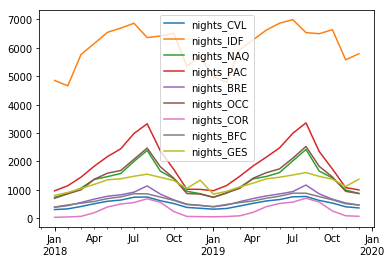

In [11]:
sarimax_forecast.plot()

In [12]:
sarimax_forecast.head()

,nights_CVL,nights_IDF,nights_NAQ,nights_PAC,nights_BRE,nights_OCC,nights_COR,nights_BFC,nights_GES
2018-01-01,302.313972,4852.514273,729.935982,962.500936,381.211299,700.642690,29.680689,392.797611,802.172387
2018-02-01,327.296774,4662.709430,864.635711,1142.441425,440.662014,858.406193,41.899647,465.096397,904.017608
2018-03-01,410.763273,5765.848165,1058.101007,1444.907053,551.455382,997.541399,63.857077,527.321959,1045.669709
2018-04-01,507.445534,6153.372178,1364.599125,1831.065791,670.559674,1370.753891,190.322310,589.277396,1190.220005
2018-05-01,595.261210,6546.513900,1462.419210,2169.370280,771.972777,1583.927654,393.942423,689.742185,1350.897108


In [13]:
# sarimax_forecast.to_csv('SARIMAX_forecast_2018-2019.csv')